In [283]:
# Import what we need for the job...
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Visualization
from IPython.display import display

In [284]:
data_file = open('datavol.txt').read()
lines = data_file.lower().split('.') #create an array of sentences
text = []
for i in range(len(lines)): #toss out short sentences, primarily to remove "," and such
    if len(lines[i]) > 8:
        text = text + [lines[i]]
interim_data = np.vstack([[text[0:-1]],[text[1:]]]).T #make a 2d array of input/output pairs of sentences
deletion_indices = []
for i in range(len(interim_data)): #check which pairs start with the end of a letter
    if((interim_data[i,1][1] == '\n' and interim_data[i,1][2] == '\n')):
        deletion_indices = deletion_indices + [i]
data = np.delete(interim_data, deletion_indices, 0) #remove those pairs that start with the end of a letter
data = np.char.lstrip(data, ' ') #remove leading spaces
for i in range(4): #remove leading endline characters
    data = np.char.lstrip(data, '\n')

In [285]:
n_seq = 100
split_point = 80
data = data[0:n_seq]
np.random.shuffle(data) # In-place modification
max_length = np.max([len(i) for i in data.flatten()]) + 2 # Add start/stop
max_length

355

In [286]:
def encode_seq(x,mapping,max_length=0):
    # String to integer
    return [mapping['<START>']] + \
           [mapping[i] for i in list(x)] + \
           [mapping['<STOP>']] + \
           [0]*(max_length-len(list(x))-2)

def decode_seq(x,mapping):
    # Integer-to-string
    try:
        idx = list(x).index(2) # Stop token?
    except:
        idx = len(list(x)) # No stop token found
    return ''.join([mapping[i] for i in list(x)[0:idx]])

In [287]:
i_to_c_pandp = ['','<START>','<STOP>'] + list({char for word in data[:,0] for char in word})
c_to_i_pandp = {i_to_c_pandp[i]:i for i in range(len(i_to_c_pandp))}
i_to_c_pandp[1] = i_to_c_pandp[2] = ''
X = np.vstack([encode_seq(x,c_to_i_pandp,max_length) for x in data[:,0]])
Y = np.vstack([encode_seq(x,c_to_i_pandp,max_length) for x in data[:,1]])
x_train = X[:split_point]
x_test = X[split_point:]
pre_y_train = Y[:,0:-1][:split_point]
pre_y_test = Y[:,0:-1][split_point:]
post_y_train = Y[:,1:][:split_point]
post_y_test = Y[:,1:][split_point:]

In [289]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                    key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="gelu"),
            keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [290]:
class MaskedTransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(MaskedTransformerBlock, self).__init__()
        self.att1 = keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                    key_dim=embed_dim)
        self.att2 = keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                    key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="gelu"),
            keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
        
    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.
        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)
    
    def call(self, inputs, training):
        input_shape = tf.shape(inputs[0])
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        mask = self.causal_attention_mask(batch_size,
                                          seq_len, seq_len,
                                          tf.bool)
        attn_output1 = self.att1(inputs[0], inputs[0],
                                 attention_mask = mask)
        attn_output1 = self.dropout1(attn_output1, training=training)
        out1 = self.layernorm1(inputs[0] + attn_output1)
        attn_output2 = self.att2(out1, inputs[1])
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm1(out1 + attn_output2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm2(out2 + ffn_output)

In [291]:
class MaskedTokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(MaskedTokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size,
                                                output_dim=embed_dim,
                                                mask_zero=True)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen+1,
                                              output_dim=embed_dim,
                                              mask_zero=True)
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = positions * tf.cast(tf.sign(x),tf.int32)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [292]:
# Custom masked loss/accuracy functions
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def MaskedSparseCategoricalCrossentropy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def MaskedSparseCategoricalAccuracy(real, pred):
    accuracies = tf.equal(tf.cast(real,tf.int64), tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

2022-04-18 22:46:59.903922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-18 22:46:59.903990: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-18 22:46:59.904072: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-gdm2z): /proc/driver/nvidia/version does not exist
2022-04-18 22:46:59.910943: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


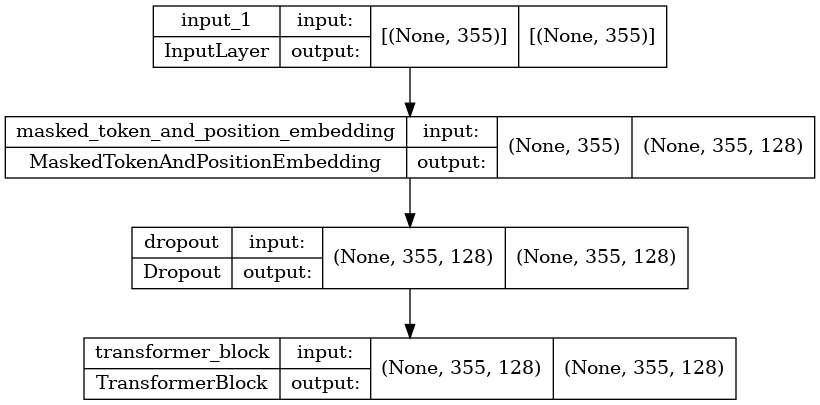

In [293]:
embed_dim = 128 # Embedding size for each token

stack = 1 # Number of stacked transformers...
num_heads = 4 # Number of attention heads (per transformer)
ff_dim = 16 # Size in nonlinear layer inside transformer(s)

dropout = 0.15

x = keras.layers.Input(shape=x_train.shape[1:])
y = x
y = MaskedTokenAndPositionEmbedding(
    maxlen=x_train.shape[1],
    vocab_size=len(c_to_i_pandp),
    embed_dim=embed_dim)(y)

# Randomly block out 15% of the input characters
y = keras.layers.Dropout(dropout,noise_shape=y.shape[:-1]+(1,))(y)

for _ in range(stack):
    y = TransformerBlock(embed_dim=embed_dim,
                         num_heads=num_heads,
                         ff_dim=ff_dim)(y)
    
encoder = keras.Model(x,y,name="Encoder")
keras.utils.plot_model(encoder,show_shapes=True,expand_nested=True)

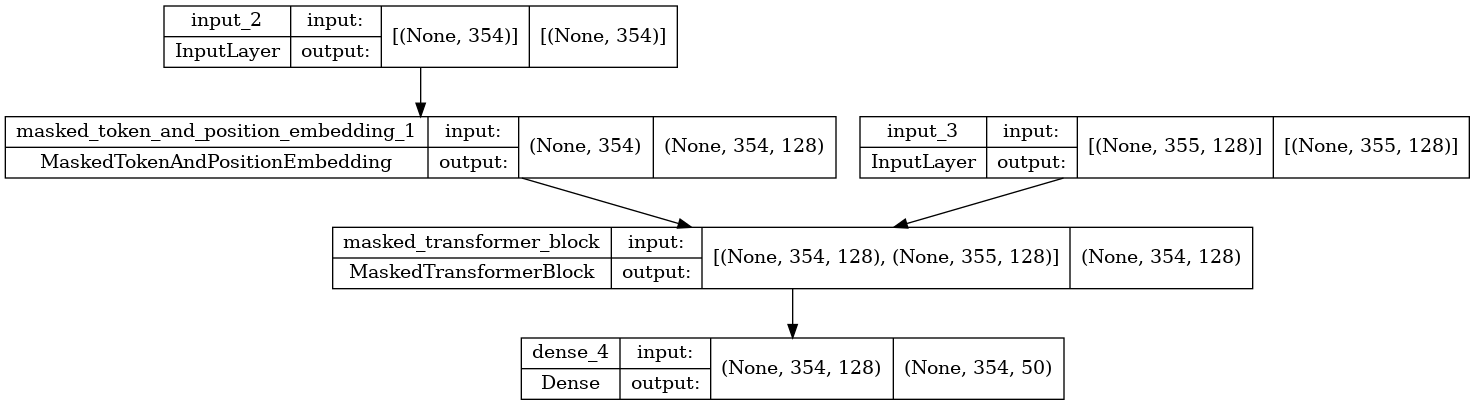

In [294]:
## Decoder Construction
x = keras.layers.Input(shape=pre_y_train.shape[1:])
c = keras.layers.Input(shape=encoder.output_shape[1:])
y = x

y = MaskedTokenAndPositionEmbedding(
    maxlen=pre_y_train.shape[1],
    vocab_size=len(c_to_i_pandp),
    embed_dim=embed_dim)(y)

for _ in range(stack):
    y = MaskedTransformerBlock(embed_dim=embed_dim,
                                num_heads=num_heads,
                                ff_dim=ff_dim)([y,c])
    
y = keras.layers.Dense(len(i_to_c_pandp))(y)


decoder = keras.Model([x, c],y,name="Decoder")
keras.utils.plot_model(decoder,show_shapes=True,expand_nested=True)

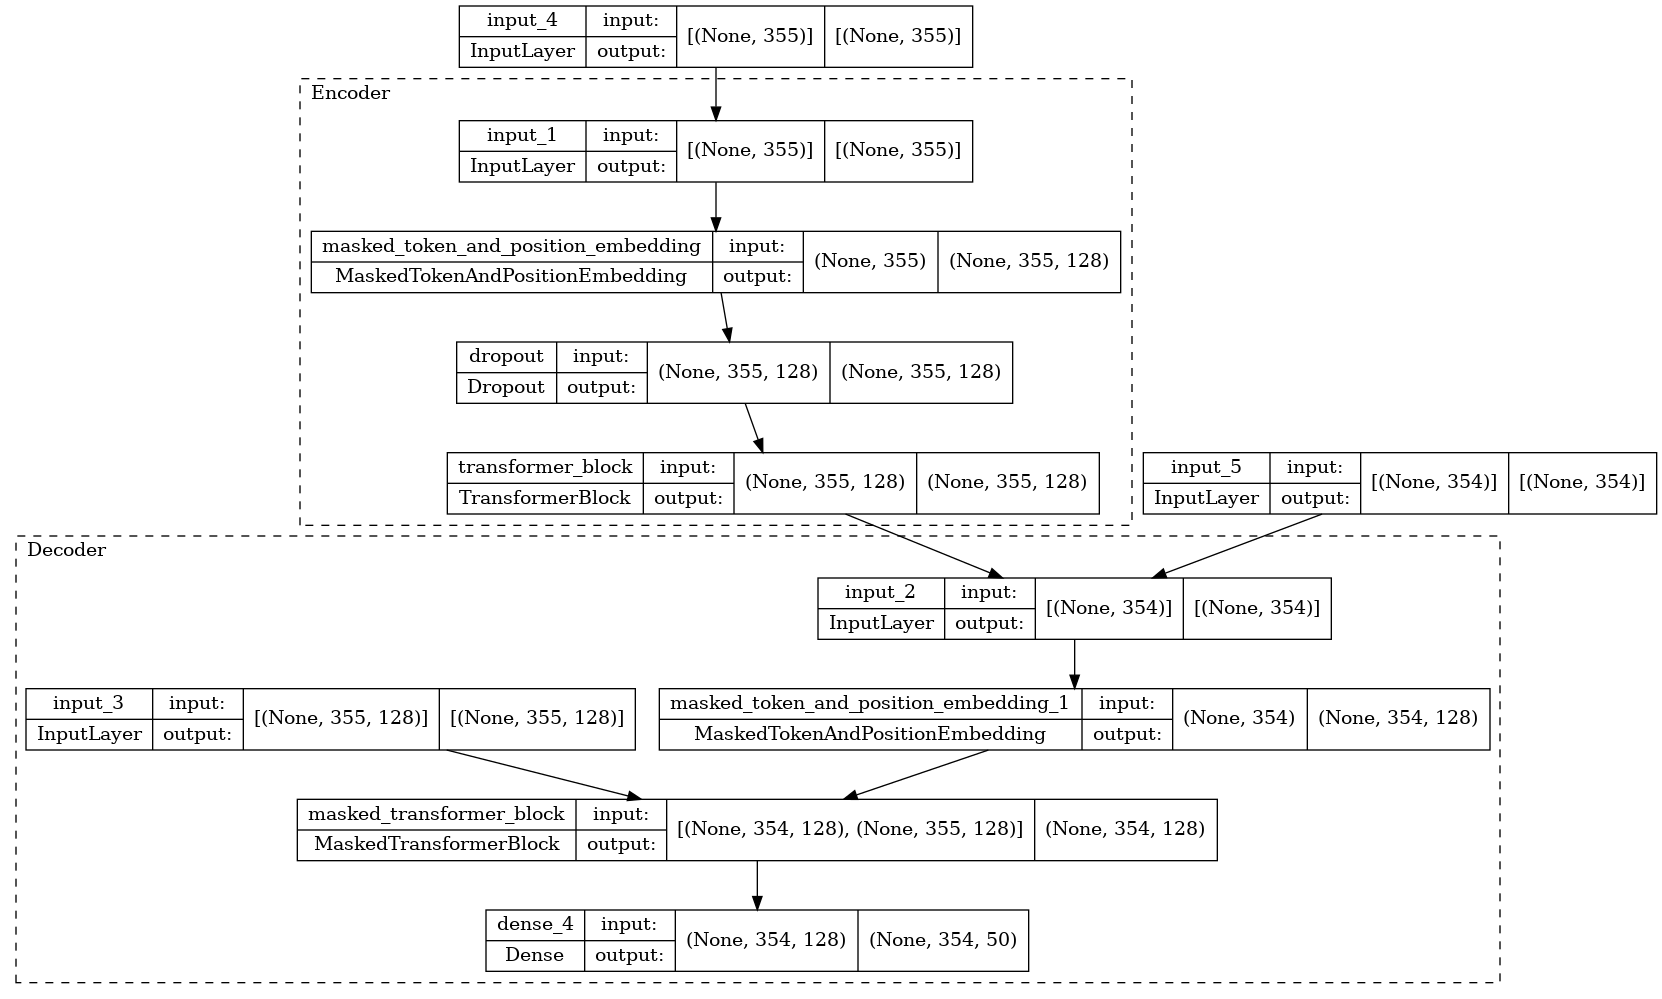

In [295]:
x_enc = keras.layers.Input(encoder.input_shape[1:])
x_dec = keras.layers.Input(decoder.input_shape[0][1:])
y = decoder([x_dec,encoder(x_enc)])
coupled = keras.Model([x_enc,x_dec],y)
# This plot will be deceptive...
keras.utils.plot_model(coupled,show_shapes=True,expand_nested=True)

In [296]:
coupled.compile(loss=MaskedSparseCategoricalCrossentropy,
optimizer=keras.optimizers.Adam(),
metrics=[MaskedSparseCategoricalAccuracy])
coupled.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 355)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 354)]        0           []                               
                                                                                                  
 Encoder (Functional)           (None, 355, 128)     320528      ['input_4[0][0]']                
                                                                                                  
 Decoder (Functional)           (None, 354, 50)      590658      ['input_5[0][0]',                
                                                                  'Encoder[0][0]']            

In [297]:
%%time

batch_size = 20 # needs to be reasonable due to activation/delta storage...
epochs = 20
history = coupled.fit([x_train,pre_y_train], post_y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=([x_test,pre_y_test], post_y_test),
            verbose=0)

CPU times: user 45min 5s, sys: 18min 56s, total: 1h 4min 1s
Wall time: 1min 50s


In [298]:
print('Training Accuracy:',coupled.evaluate([x_train,pre_y_train],post_y_train)[1]*100.0,'%')
print('Validation Accuracy:',coupled.evaluate([x_test,pre_y_test],post_y_test)[1]*100.0,'%')

3/3 [==============================] - 3s 580ms/step - loss: 1.9948 - MaskedSparseCategoricalAccuracy: 0.3761
Training Accuracy: 37.607213854789734 %
1/1 [==============================] - 0s 472ms/step - loss: 2.7461 - MaskedSparseCategoricalAccuracy: 0.2236
Validation Accuracy: 22.3551943898201 %


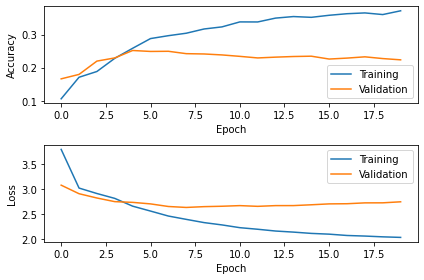

In [299]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['MaskedSparseCategoricalAccuracy'])
plt.plot(history.history['val_MaskedSparseCategoricalAccuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='upper right')
plt.tight_layout()
plt.show()

In [303]:
# Teacher forcing - Training data
result = coupled.predict([x_train,pre_y_train])
MaskedSparseCategoricalAccuracy(post_y_train,result).numpy()*100.0

37.77349591255188

In [304]:
# Teacher forcing - Validation data
result = coupled.predict([x_test,pre_y_test])
MaskedSparseCategoricalAccuracy(post_y_test,result).numpy()*100.0

22.3551943898201

In [ ]:
# Without teacher forcing - Training data
# Get the gestalt context for the input sequence(s)
context = encoder.predict(x_train)

# Prep a starting token...
token = np.zeros(pre_y_train.shape)
token[:,0] = 1 # Just start tokens

for x in range(post_y_train.shape[1]-1):
    result = decoder.predict([token,context]).argmax(-1)
    token[:,x+1] = result[:,x]
result = decoder.predict([token,context])
MaskedSparseCategoricalAccuracy(post_y_train,result).numpy()*100.0

In [ ]:
# Without teacher forcing - Validation data
# Get the gestalt context for the input sequence(s)
context = encoder.predict(x_test)

# Prep a starting token...
token = np.zeros(pre_y_test.shape)
token[:,0] = 1 # Just start tokens

for x in range(post_y_test.shape[1]-1):
    result = decoder.predict([token,context]).argmax(-1)
    token[:,x+1] = result[:,x]
result = decoder.predict([token,context])
MaskedSparseCategoricalAccuracy(post_y_test,result).numpy()*100.0